## Redes Convolucionales
#### Ejemplo clasificación de perros y gatos para CAPTCHA

Este notebook utiliza datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview). En esta competicion se utiliza Asirra (Animal Species Image Recognition for Restricting Access), CAPTCHA que sirve para diferenciar entre una persona o una máquina accediendo a una página web. Este tipo de "pruebas" se utilizan para evitar emails de spam, y ataques por fuerza bruta contra servidores.

En este notebook vamos a probar que hay técnicas de clasificado automáticas de imágenes mediante redes neuronales, que con las que se intenta saltar CAPTCHA

# Import Library

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Define Constants
Tendremos una serie de constantes como las dimensiones de las imágenes, que serán fijas a lo largo de todo el notebook

In [2]:
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 25

# Prepare Training Data
1. Descárgate el dataset
2. Descomprime el dataset y guardalo en la ruta que quieras del ordenador.
3. En este punto vamos guardar en una lista las etiquetas de cada foto.

In [3]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = ROOT_PATH + "\\data\\PROF_train\\PROF_train\\train\\"
TEST_PATH = ROOT_PATH + "\\data\\PROF_test1\\PROF_test1\\test1\\"

In [16]:
##### CODE #####

# Listar todos los archivos de la carpeta de train (TRAIN_PATH)
filenames = os.listdir(TRAIN_PATH)

# Lista vacia
categories = []

# Iterar
for filename in filenames:
    # Saco el nombre
    category = filename.split('.')[0]
    
    # If else
    # Guardo en lista
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}) 

In [17]:
df

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


In [22]:
from sklearn.utils import shuffle
for vez in range(10000):
    df = shuffle(df)

In [23]:
df

,filename,category
6175,cat.4305.jpg,0
1961,cat.11762.jpg,0
15851,dog.1764.jpg,1
13287,dog.10705.jpg,1
5179,cat.3409.jpg,0
...,...,...
8963,cat.6815.jpg,0
5628,cat.3813.jpg,0
24738,dog.9763.jpg,1
4037,cat.2381.jpg,0


### See Total In count

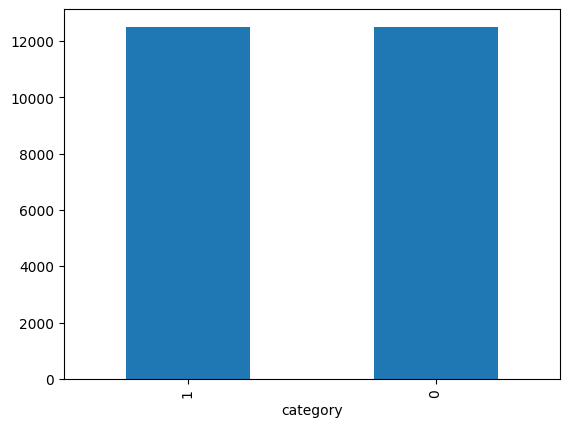

In [14]:
df['category'].value_counts().plot.bar();

# See sample image

(500, 356, 3)
245


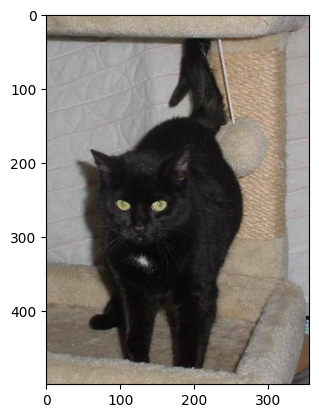

In [15]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)

print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [16]:
image

array([[[165, 150, 131],
        [162, 147, 128],
        [161, 146, 127],
        ...,
        [143, 142, 140],
        [144, 143, 141],
        [144, 143, 141]],

       [[165, 150, 131],
        [162, 147, 128],
        [162, 147, 128],
        ...,
        [145, 144, 142],
        [147, 146, 144],
        [147, 146, 144]],

       [[164, 149, 130],
        [161, 146, 127],
        [161, 146, 127],
        ...,
        [147, 146, 144],
        [150, 149, 147],
        [150, 149, 147]],

       ...,

       [[176, 162, 149],
        [174, 160, 147],
        [174, 161, 145],
        ...,
        [ 90,  91,  93],
        [ 91,  92,  94],
        [ 92,  93,  95]],

       [[172, 158, 145],
        [170, 156, 143],
        [171, 158, 142],
        ...,
        [ 92,  93,  95],
        [ 93,  94,  96],
        [ 94,  95,  97]],

       [[168, 154, 141],
        [166, 152, 139],
        [167, 154, 138],
        ...,
        [ 93,  94,  96],
        [ 94,  95,  97],
        [ 95,  96,  98]]

# Resize image
Cargar todas las imágenes a la vez es un problema ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (500, 415, 3)
Tamaño imagen reshape: (100, 100, 3)


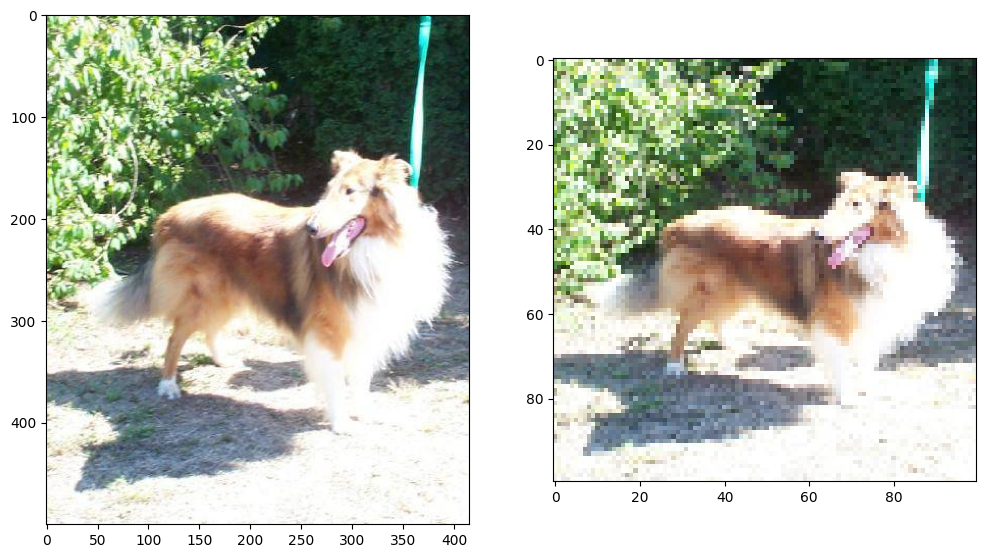

In [17]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(TRAIN_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

Tamaño imagen original: (439, 499)


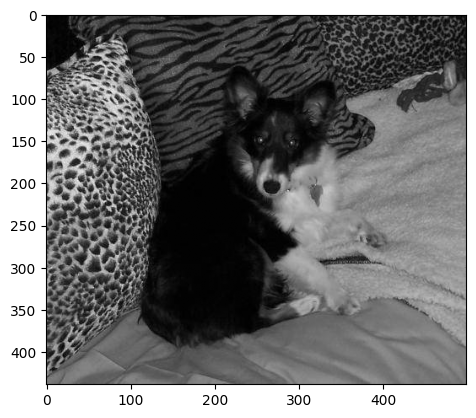

In [18]:
sample = random.choice(filenames)

image = cv2.imread(filename = TRAIN_PATH + sample, flags = cv2.IMREAD_GRAYSCALE)

print("Tamaño imagen original:", image.shape)
plt.imshow(image, cmap='gray');

# Load data
Llega el momento de cargar los datos. Ya no estan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [19]:
def read_data(path, im_size):
    X = []
    Y = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
        
        # Leer la imagen a color y aplicarle el resize
        image = imread(path + file)
        smallimage = cv2.resize(image, (im_size, im_size))
        
        # Guardo en X
        X.append(smallimage)
        
        category = file.split('.')[0]
        # Miro si es perro y gato para guardar en Y
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)
        

    return np.array(X), np.array(Y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18750, 100, 100, 3)
(6250, 100, 100, 3)
(18750,)
(6250,)


(100, 100, 3)


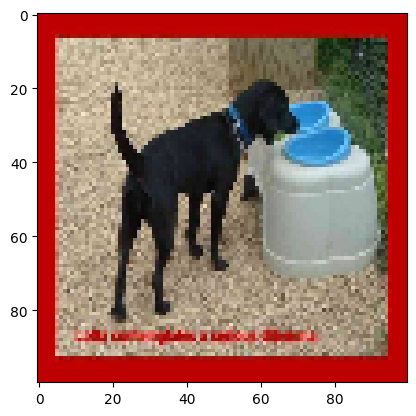

In [20]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [21]:
X_train[0]

array([[[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]],

       [[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]],

       [[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]],

       ...,

       [[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]],

       [[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]],

       [[189,   1,   0],
        [189,   1,   0],
        [189,   1,   0],
        ...,
        [189,   1,   0],
        [189,   1,   0],
        [189,   1,   0]]

# Normalized data
Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [22]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [23]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Save data
Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [24]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test)

Para cargar

In [4]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']


# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la metrica, se puede usar un binary_crossentropy, al ser un target binario. O 

In [5]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

layers = [
    keras.layers.Input(shape=IMAGE_SIZE),
    keras.layers.Conv2D(32, (3,3), activation='relu'), # (100, 100, 3)
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
    
]

model = keras.Sequential(layers)

model.compile(optimizer = RMSprop(learning_rate=1e-4),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])


In [29]:
#64*(3*3)*3+ 64

1792

In [ ]:
#128*(3*3)*3

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,433 (4.92 MB)

 Trainable params: 1,290,433 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks
#### Early Stopping

In [7]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [8]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model.keras")

# Fit the model

In [9]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=1)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 71s 134ms/step - accuracy: 0.5704 - loss: 0.6711 - val_accuracy: 0.5475 - val_loss: 0.6999
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 127ms/step - accuracy: 0.6484 - loss: 0.6233 - val_accuracy: 0.6944 - val_loss: 0.5847
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 120ms/step - accuracy: 0.7113 - loss: 0.5607 - val_accuracy: 0.7179 - val_loss: 0.5526
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 129ms/step - accuracy: 0.7527 - loss: 0.5048 - val_accuracy: 0.7677 - val_loss: 0.4892
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.7795 - loss: 0.4670 - val_accuracy: 0.7824 - val_loss: 0.4626
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 142ms/step - accuracy: 0.7999 - loss: 0.4365 - val_accuracy: 0.7963 - val_loss: 0.4489
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 137ms/step - accuracy: 0.8121 - loss: 0.4121 - val_accuracy: 0.8149 - val_loss: 0.4144
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.8219 - loss: 0

# Evaluate
Probemos los datos en el conjunto de test.

In [10]:
results = model.evaluate(X_test, y_test)
results

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8246 - loss: 0.4641


[0.46413910388946533, 0.8246399760246277]

In [11]:
model.predict(X_test).round(0)

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], shape=(6250, 1), dtype=float32)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, model.predict(X_test).round(0))

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


array([[2520,  595],
       [ 501, 2634]])

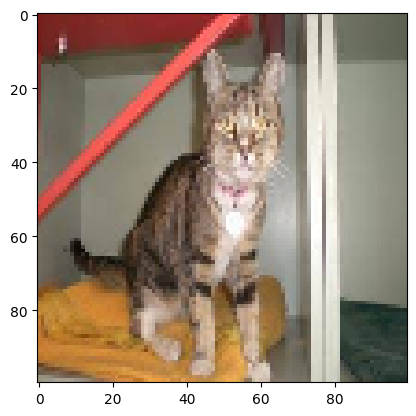

In [13]:
plt.imshow(X_test[-1]);

In [14]:
predictions = model.predict(X_test[-1:]).round(0)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


array([[0.]], dtype=float32)

# Image data generator

In [24]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("Categorias:", df['category'].unique())
df.head()

Categorias: ['cat' 'dog']


,filename,category
6175,cat.4305.jpg,cat
1961,cat.11762.jpg,cat
15851,dog.1764.jpg,dog
13287,dog.10705.jpg,dog
5179,cat.3409.jpg,cat


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

example_df = df.sample(n=1).reset_index(drop=True) # una foto
example_df

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    TRAIN_PATH,
    x_col = 'filename',
    y_col = 'category',
    target_size = (100, 100)
)

Found 1 validated image filenames belonging to 1 classes.


In [27]:
example_df

,filename,category
0,dog.7558.jpg,dog


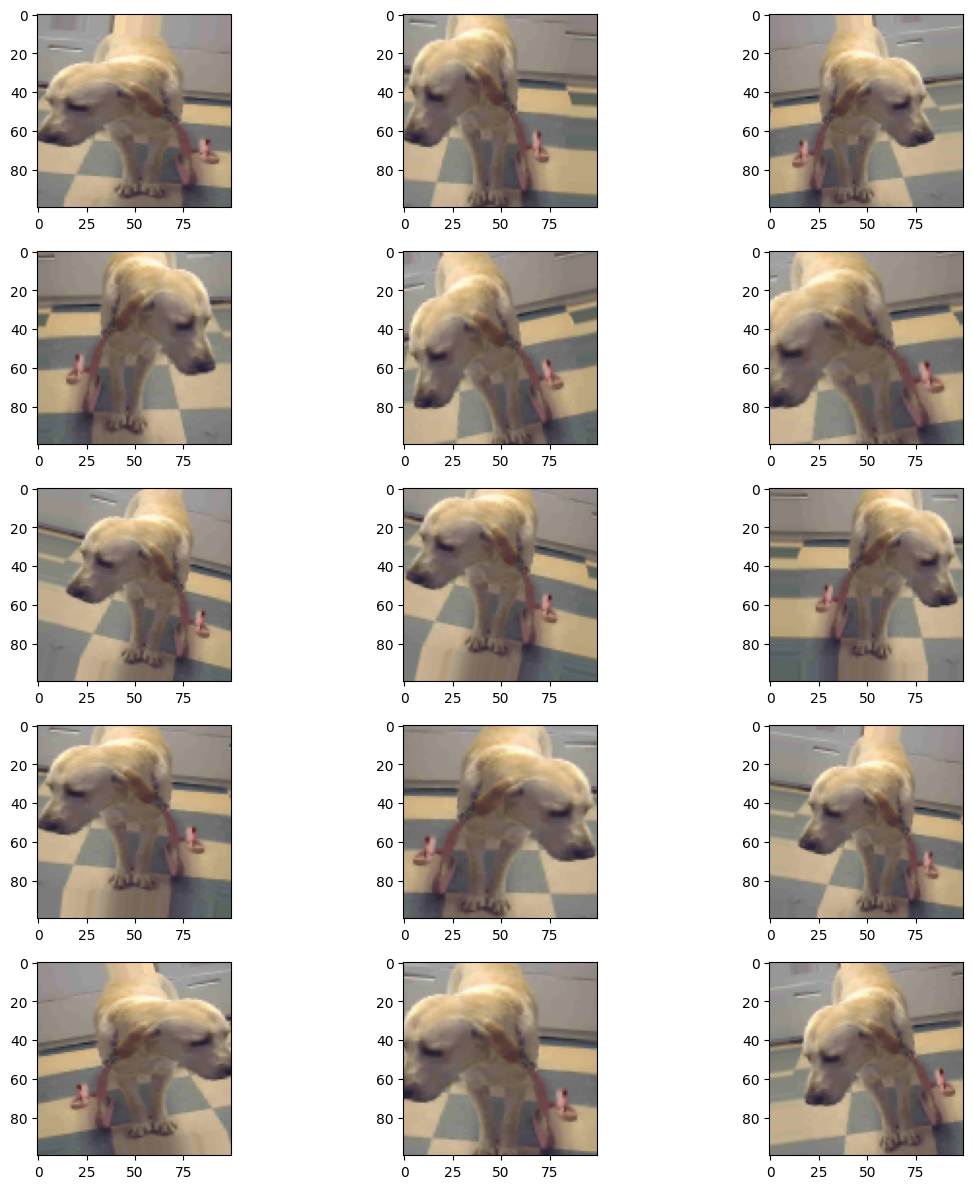

In [28]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Training Generator

In [29]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    shear_range = 0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# 70% train, 30% test --> 0.7 *0.7 train, 0.3 * 0.7 val, 0.3 test
# como el test no tiene etiquetas por ser de kaggle
# usaremos el 70% de train para entrenar, dejaremos el último 30% para testear
# y del primer 70% usaremos el primer 70% para entrenar y el último 30% para validar
train_generator = train_datagen.flow_from_dataframe(
    df.iloc[:round(0.7*0.7*len(df)),:], 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 12250 validated image filenames belonging to 2 classes.


### Validation Generator

In [30]:

validation_datagen = ImageDataGenerator(rescale=1./255) # ¡¡solo se reescala!!
validation_generator = validation_datagen.flow_from_dataframe(
    df.iloc[round(0.7*0.7*len(df)):round(0.7*len(df)),:], 
    TRAIN_PATH, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)


Found 5250 validated image filenames belonging to 2 classes.


# Fit Model

In [31]:
model = keras.Sequential(layers)

model.compile(optimizer = RMSprop(learning_rate=1e-4),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [32]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = validation_generator
)

Epoch 1/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 228s 592ms/step - accuracy: 0.7997 - loss: 0.4373 - val_accuracy: 0.9065 - val_loss: 0.2628
Epoch 2/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 118s 308ms/step - accuracy: 0.8171 - loss: 0.4032 - val_accuracy: 0.8931 - val_loss: 0.2697
Epoch 3/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 91s 237ms/step - accuracy: 0.8201 - loss: 0.3939 - val_accuracy: 0.8985 - val_loss: 0.2649
Epoch 4/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 101s 264ms/step - accuracy: 0.8212 - loss: 0.3869 - val_accuracy: 0.8893 - val_loss: 0.2712
Epoch 5/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 98s 256ms/step - accuracy: 0.8307 - loss: 0.3779 - val_accuracy: 0.8926 - val_loss: 0.2642
Epoch 6/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 102s 267ms/step - accuracy: 0.8325 - loss: 0.3690 - val_accuracy: 0.8933 - val_loss: 0.2725
Epoch 7/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 102s 266ms/step - accuracy: 0.8364 - loss: 0.3651 - val_accuracy: 0.8981 - val_loss: 0.2574
Epoch 8/25
383/383 ━━━━━━━━━━━━━━━━━━━━ 100s 260ms/step - accuracy: 0.8419 - l

# Virtualize Training

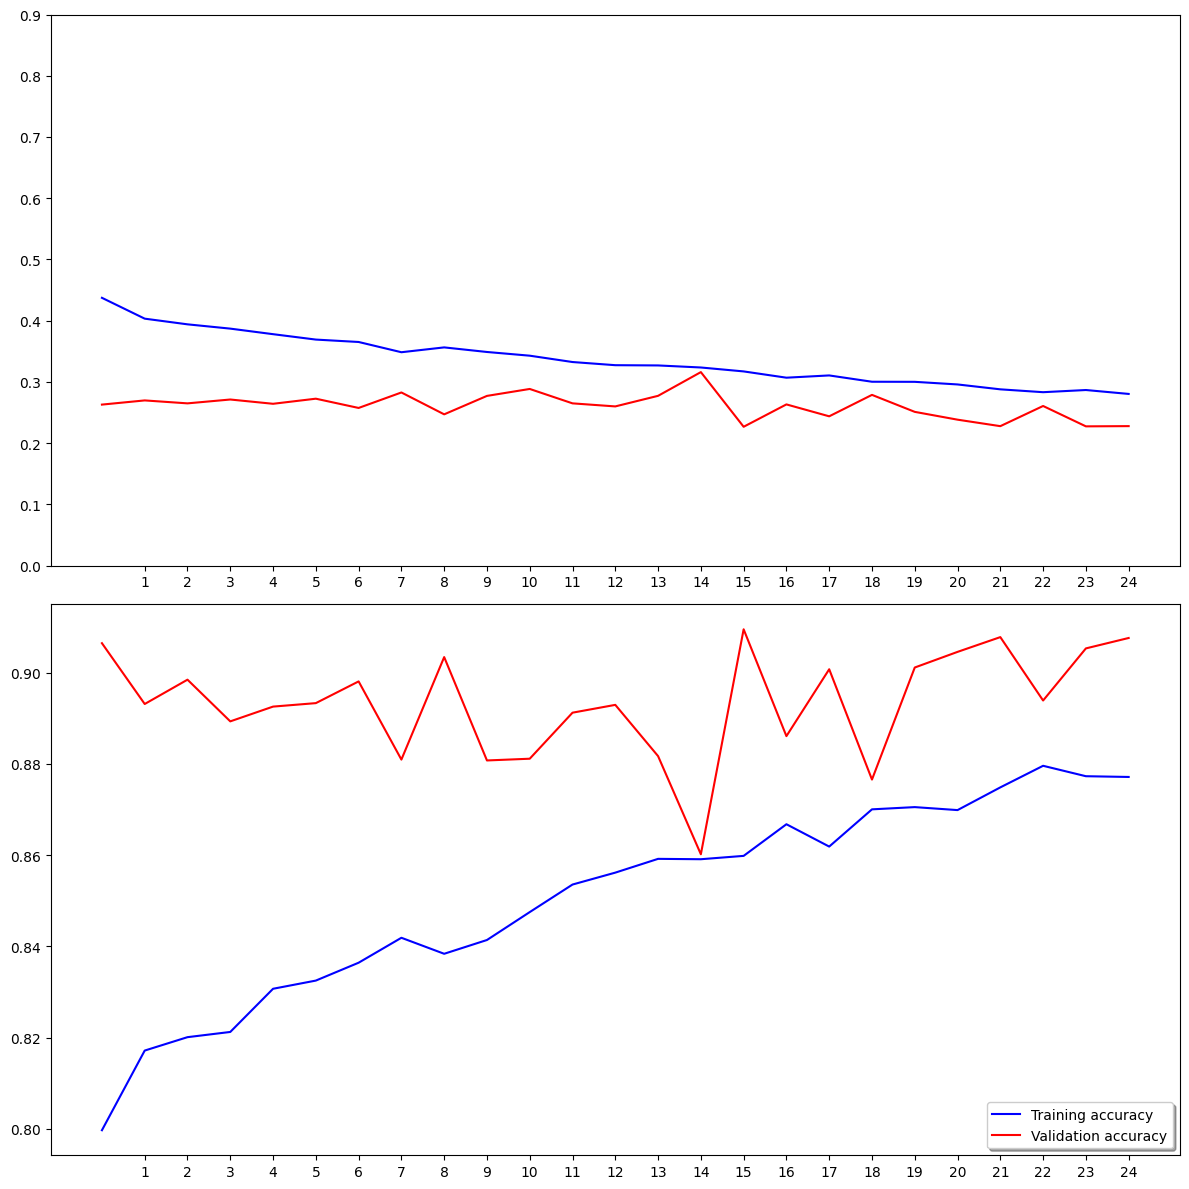

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [34]:
df.iloc[round(0.7*len(df)):,:]

,filename,category
8910,cat.6768.jpg,cat
433,cat.10387.jpg,cat
9395,cat.7203.jpg,cat
16863,dog.2675.jpg,dog
23248,dog.8421.jpg,dog
...,...,...
8963,cat.6815.jpg,cat
5628,cat.3813.jpg,cat
24738,dog.9763.jpg,dog
4037,cat.2381.jpg,cat


In [35]:
df_test = df.iloc[round(0.7*len(df)):,:]

In [ ]:
'dog.12189.jpg' in ['dog.12189.jpg']

In [38]:
def read_test_data(path, im_size, df_test):
    Xtest = []
    Ytest = []

    ##### CODE #####
    # Iterar sobre todo lo que haya en path
    for file in os.listdir(path):
            
        if file in df_test['filename'].tolist():
        
            # Leer la imagen a color y aplicarle el resize
            image = imread(path + file)
            smallimage = cv2.resize(image, (im_size, im_size))
        
        
            # Guardo en X
            Xtest.append(smallimage)
        
            category = file.split('.')[0]
            # Miro si es perro y gato para guardar en Y
            if category == 'dog':
                Ytest.append(1)
            else:
                Ytest.append(0)
        

    return np.array(Xtest), np.array(Ytest)
    

X_test2, y_test2 = read_test_data(TRAIN_PATH, IMAGE_WIDTH, df_test)

print(X_test2.shape)
print(y_test2.shape)

(7500, 100, 100, 3)
(7500,)


In [39]:
#testear con el último 30%

results2 = model.evaluate(X_test2, y_test2)
results2


235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8807 - loss: 25.3202


[25.320199966430664, 0.8806666731834412]

In [40]:
confusion_matrix(y_test2, model.predict(X_test2).round(0))

235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


array([[3086,  688],
       [ 207, 3519]])

In [ ]:
# dije 0 gato pero era 1 perro, dije 207 veces gato pero era perro
# 688 veces digo perro pero es gato

In [ ]:
df.iloc[:round(0.7*0.7*len(df)),:].category.value_counts()  # train

category
cat    6131
dog    6119
Name: count, dtype: int64

In [ ]:
df.iloc[round(0.7*0.7*len(df)):round(0.7*len(df)),:].category.value_counts() # validación

category
dog    2655
cat    2595
Name: count, dtype: int64

In [ ]:
df.iloc[round(0.7*len(df)):,:].category.value_counts() # test

category
cat    3774
dog    3726
Name: count, dtype: int64